# Trabajo Práctico N° 7

### 1. Configuración inicial de Spark

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Crear sesión de spark
spark = SparkSession.builder  \
    .appName("TP7-Cybersecurity-Analisys") \
    .config("spark.sql.adaptative.enabled", "true") \
    .getOrCreate()

# Configurar para mostrar más filas
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

### 2. Cargar el archivo CSV

In [0]:
# Opción 1: Leer directamente desde la tabla que ya está cargada
CYBER_ATTACKS = f"workspace.default.global_cybersecurity_threats_2015_2024"
df = spark.sql("SELECT * FROM workspace.default.global_cybersecurity_threats_2015_2024")

# Mostrar los datos
print("=== ESQUEMA DEL DATASET ===")
df.printSchema()
print("\n<=== PRIMERAS 10 FILAS DEL DATASET ===>")
df.show(10, truncate=False)
print(f"\n=== TOTAL DE REGISTROS: {df.count()} ===")


=== ESQUEMA DEL DATASET ===
root
 |-- Country: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Attack Type: string (nullable = true)
 |-- Target Industry: string (nullable = true)
 |-- Financial Loss (in Million $): double (nullable = true)
 |-- Number of Affected Users: long (nullable = true)
 |-- Attack Source: string (nullable = true)
 |-- Security Vulnerability Type: string (nullable = true)
 |-- Defense Mechanism Used: string (nullable = true)
 |-- Incident Resolution Time (in Hours): long (nullable = true)


<=== PRIMERAS 10 FILAS DEL DATASET ===>
+-------+----+-----------------+------------------+-----------------------------+------------------------+-------------+---------------------------+----------------------+-----------------------------------+
|Country|Year|Attack Type      |Target Industry   |Financial Loss (in Million $)|Number of Affected Users|Attack Source|Security Vulnerability Type|Defense Mechanism Used|Incident Resolution Time (in Hours)|
+-------

### Realizamos consultas básicas de análisis exploratorios

In [0]:
# Consulta: Conteo total de registros
print("=== TOTAL DE REGISTROS ===")
total_registros = spark.sql(f"SELECT count(*) AS total_registros FROM {CYBER_ATTACKS}").show(truncate=False)

# Años cubiertos en el dataset
print("=== AÑOS CUBIERTOS EN EL DATASET ===")
años_cubiertos = spark.sql(f"SELECT DISTINCT Year FROM {CYBER_ATTACKS}").show(truncate=False)

# Tipos de ataques únicos
print("=== TIPOS DE ATAQUES QUE FIGURAN EN EL DATASET ===")
tipos_ataques = spark.sql(f"SELECT DISTINCT `Attack Type` FROM {CYBER_ATTACKS} ORDER BY `Attack Type`").show(truncate=False)

# Industrias objetivo
print("=== INDUSTRIAS OBJETIVO ===")
industrias_objetivo = spark.sql(f"SELECT DISTINCT `Target Industry` FROM {CYBER_ATTACKS} ORDER BY `Target Industry`").show(truncate=False)

=== TOTAL DE REGISTROS ===
+---------------+
|total_registros|
+---------------+
|3000           |
+---------------+

=== AÑOS CUBIERTOS EN EL DATASET ===
+----+
|Year|
+----+
|2019|
|2017|
|2024|
|2018|
|2016|
|2023|
|2022|
|2015|
|2021|
|2020|
+----+

=== TIPOS DE ATAQUES ÚNICOS ===
+-----------------+
|Attack Type      |
+-----------------+
|DDoS             |
|Malware          |
|Man-in-the-Middle|
|Phishing         |
|Ransomware       |
|SQL Injection    |
+-----------------+

=== INDUSTRIAS OBJETIVO ===
+------------------+
|Target Industry   |
+------------------+
|Banking           |
|Education         |
|Government        |
|Healthcare        |
|IT                |
|Retail            |
|Telecommunications|
+------------------+



## 3. Limpieza de datos

In [0]:
# Verificar el estado inicial
print("=== ESTADO INICIAL ===")
print(f"Registros totales: {df.count()}")
print(f"Columnas: {len(df.columns)}")

# A. Identificar valores nulos
print("\n=== VALORES NULOS POR COLUMNA ===")
from pyspark.sql.functions import col, sum as spark_sum

# Contar nulos por columna
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show(vertical=True)

# B. Eliminar duplicados exactos
print("\n=== ELIMINANDO DUPLICADOS EXACTOS ===")
df_clean = df.dropDuplicates()
print(f"Registros después de eliminar duplicados: {df_clean.count()}")

# C. Eliminar duplicados basados en columnas clave. Son registros que tienen exactamente los mismos valores en las columnas clave, pero que podrían tener diferencias en otras columnas. Por lo tanto representan el mismo incidente.
#df_clean = df_clean.dropDuplicates(["Year", "Country", "Attack Type", "Target Industry"])
#print(f"Registros después de eliminar duplicados clave: {df_clean.count()}")

=== ESTADO INICIAL ===
Registros totales: 3000
Columnas: 10

=== VALORES NULOS POR COLUMNA ===
-RECORD 0----------------------------------
 Country                             | 0   
 Year                                | 0   
 Attack Type                         | 0   
 Target Industry                     | 0   
 Financial Loss (in Million $)       | 0   
 Number of Affected Users            | 0   
 Attack Source                       | 0   
 Security Vulnerability Type         | 0   
 Defense Mechanism Used              | 0   
 Incident Resolution Time (in Hours) | 0   


=== ELIMINANDO DUPLICADOS EXACTOS ===
Registros después de eliminar duplicados: 3000


## Investigar duplicados 

In [0]:
# 1. Análisis de la distribución de duplicados
print("=== ANÁLISIS DE DISTRIBUCIÓN DE DUPLICADOS ===")

duplicate_analysis = df.groupBy("Year", "Country", "Attack Type", "Target Industry") \
    .agg(count("*").alias("cantidad_duplicados")) \
    .filter(col("cantidad_duplicados") > 1) \
    .groupBy("cantidad_duplicados") \
    .agg(count("*").alias("grupos_con_esta_cantidad")) \
    .orderBy("cantidad_duplicados", ascending=False)

print("Distribución de grupos duplicados:")
duplicate_analysis.show()

# 2. Ver los grupos con más duplicados
print("\n=== TOP 10 GRUPOS CON MÁS DUPLICADOS ===")
top_duplicate_groups = df.groupBy("Year", "Country", "Attack Type", "Target Industry") \
    .agg(
        count("*").alias("total_registros"),
        mean("Financial Loss (in Million $)").alias("perdida_promedio"),
        stddev("Financial Loss (in Million $)").alias("desviacion_perdida"),
        mean("Number of Affected Users").alias("usuarios_promedio")
    ) \
    .filter(col("total_registros") > 1) \
    .orderBy("total_registros", ascending=False)

top_duplicate_groups.show(10, truncate=False)

# 3. Examinar en detalle un grupo específico con muchos duplicados
print("\n=== EXAMINANDO UN GRUPO CON MÚLTIPLES REGISTROS ===")
sample_high_duplicate = top_duplicate_groups.first()

if sample_high_duplicate:
    print(f"Analizando grupo: {sample_high_duplicate['Year']}, {sample_high_duplicate['Country']}, " +
          f"{sample_high_duplicate['Attack Type']}, {sample_high_duplicate['Target Industry']}")
    
    grupo_detalle = df.filter(
        (col("Year") == sample_high_duplicate["Year"]) &
        (col("Country") == sample_high_duplicate["Country"]) &
        (col("Attack Type") == sample_high_duplicate["Attack Type"]) &
        (col("Target Industry") == sample_high_duplicate["Target Industry"])
    )
    
    print(f"Total de registros en este grupo: {grupo_detalle.count()}")
    grupo_detalle.show(truncate=False)

# 4. Comparar las diferencias entre registros duplicados
print("\n=== COMPARANDO DIFERENCIAS ENTRE REGISTROS DUPLICADOS ===")

from pyspark.sql.functions import min, max, avg

diferencias_duplicados = df.groupBy("Year", "Country", "Attack Type", "Target Industry") \
    .agg(
        count("*").alias("cantidad"),
        min("Financial Loss (in Million $)").alias("perdida_min"),
        max("Financial Loss (in Million $)").alias("perdida_max"),
        avg("Financial Loss (in Million $)").alias("perdida_promedio"),
        min("Number of Affected Users").alias("usuarios_min"),
        max("Number of Affected Users").alias("usuarios_max"),
        min("Incident Resolution Time (in Hours)").alias("tiempo_min"),
        max("Incident Resolution Time (in Hours)").alias("tiempo_max")
    ) \
    .filter(col("cantidad") > 1) \
    .withColumn("diferencia_perdida", col("perdida_max") - col("perdida_min")) \
    .withColumn("diferencia_usuarios", col("usuarios_max") - col("usuarios_min")) \
    .orderBy("diferencia_perdida", ascending=False)

print("Grupos con mayores diferencias en métricas:")
diferencias_duplicados.show(10, truncate=False)

# 5. Análisis por año - ¿Hay años con más duplicados?
print("\n=== ANÁLISIS DE DUPLICADOS POR AÑO ===")
duplicados_por_año = df.groupBy("Year", "Country", "Attack Type", "Target Industry") \
    .agg(count("*").alias("cantidad")) \
    .filter(col("cantidad") > 1) \
    .groupBy("Year") \
    .agg(count("*").alias("grupos_duplicados")) \
    .orderBy("Year")

print("Cantidad de grupos duplicados por año:")
duplicados_por_año.show()

# 6. Verificar si los duplicados tienen diferentes fuentes de ataque
print("\n=== ¿LOS DUPLICADOS TIENEN DIFERENTES FUENTES? ===")
if sample_high_duplicate:
    grupo_fuentes = df.filter(
        (col("Year") == sample_high_duplicate["Year"]) &
        (col("Country") == sample_high_duplicate["Country"]) &
        (col("Attack Type") == sample_high_duplicate["Attack Type"]) &
        (col("Target Industry") == sample_high_duplicate["Target Industry"])
    ).select("Attack Source").distinct()
    
    print("Fuentes de ataque distintas en el mismo grupo:")
    grupo_fuentes.show(truncate=False)

# 7. Resumen estadístico de las diferencias
print("\n=== RESUMEN ESTADÍSTICO DE LAS DIFERENCIAS ===")
resumen_diferencias = diferencias_duplicados.select(
    avg("diferencia_perdida").alias("diferencia_promedio_perdida"),
    max("diferencia_perdida").alias("diferencia_maxima_perdida"),
    avg("diferencia_usuarios").alias("diferencia_promedio_usuarios"),
    max("diferencia_usuarios").alias("diferencia_maxima_usuarios")
)

resumen_diferencias.show()

# 8. Estrategia recomendada basada en el análisis
print("\n" + "="*50)
print("RECOMENDACIÓN BASADA EN EL ANÁLISIS")
print("="*50)

total_grupos_duplicados = top_duplicate_groups.count()
print(f"Total de grupos con duplicados: {total_grupos_duplicados}")
print(f"Registros eliminados por duplicados clave: {3000 - 2180}")

# Tomar decisión basada en las diferencias
if resumen_diferencias.first()["diferencia_promedio_perdida"] < 10:
    print("RECOMENDACIÓN: Los duplicados tienen métricas similares. Puedes eliminar con confianza.")
    print("Estrategia: Conservar el primer registro de cada grupo.")
else:
    print("RECOMENDACIÓN: Los duplicados tienen métricas significativamente diferentes.")
    print("Estrategia: Investigar manualmente o conservar el registro con valores promedios.")

=== ANÁLISIS DE DISTRIBUCIÓN DE DUPLICADOS ===
Distribución de grupos duplicados:
+-------------------+------------------------+
|cantidad_duplicados|grupos_con_esta_cantidad|
+-------------------+------------------------+
|                  6|                       1|
|                  5|                       1|
|                  4|                      17|
|                  3|                     121|
|                  2|                     518|
+-------------------+------------------------+


=== TOP 10 GRUPOS CON MÁS DUPLICADOS ===
+----+-------+-------------+---------------+---------------+------------------+------------------+-----------------+
|Year|Country|Attack Type  |Target Industry|total_registros|perdida_promedio  |desviacion_perdida|usuarios_promedio|
+----+-------+-------------+---------------+---------------+------------------+------------------+-----------------+
|2017|France |SQL Injection|Healthcare     |6              |54.925000000000004|30.886234312392308|457

### Creamos un identificador único para cada incidente

In [0]:
# Estrategia 1: Crear un identificador único para cada incidente
from pyspark.sql.functions import monotonically_increasing_id

df_with_id = df.withColumn("incident_id", monotonically_increasing_id())

# Estrategia 2: Agregar columnas que capturen la variabilidad
df_enhanced = df_with_id.withColumn(
    "incident_complexity",
    when(col("Attack Source") == "Nation-state", "High")
    .when(col("Attack Source") == "Hacker Group", "Medium")
    .otherwise("Low")
)

# Estrategia 3: Para análisis agregados, usar promedio en lugar de eliminar
df_for_analysis = df.groupBy("Year", "Country", "Attack Type", "Target Industry").agg(
    avg("Financial Loss (in Million $)").alias("avg_financial_loss"),
    avg("Number of Affected Users").alias("avg_affected_users"),
    avg("Incident Resolution Time (in Hours)").alias("avg_resolution_time"),
    count("*").alias("incident_count"),
    collect_set("Attack Source").alias("attack_sources")
)

print("=== DATOS AGRUPADOS CORRECTAMENTE ===")
df_for_analysis.show(10, truncate=False)

=== DATOS AGRUPADOS CORRECTAMENTE ===
+----+-------+-----------------+------------------+------------------+------------------+-------------------+--------------+----------------------------+
|Year|Country|Attack Type      |Target Industry   |avg_financial_loss|avg_affected_users|avg_resolution_time|incident_count|attack_sources              |
+----+-------+-----------------+------------------+------------------+------------------+-------------------+--------------+----------------------------+
|2019|China  |Phishing         |Education         |80.53             |773169.0          |63.0               |1             |[Hacker Group]              |
|2019|China  |Ransomware       |Retail            |34.135            |235611.0          |67.5               |2             |[Hacker Group, Nation-state]|
|2017|India  |Man-in-the-Middle|IT                |53.665000000000006|665751.5          |17.5               |2             |[Hacker Group, Insider]     |
|2024|UK     |Ransomware       |Teleco

In [0]:
# REVERTIR la eliminación de duplicados - mantener todos los registros
df_clean = df  # Volvemos al dataset original

# En lugar de eliminar, agregamos un identificador único
from pyspark.sql.functions import monotonically_increasing_id, collect_set

df_clean = df.withColumn("incident_id", monotonically_increasing_id())

print("=== ESTRATEGIA CORREGIDA ===")
print(f"Registros totales conservados: {df_clean.count()}")
print("Ahora cada incidente tiene ID único, incluso si comparte categorías")

# Para análisis agregados, usamos promedios
print("\n=== EJEMPLO DE ANÁLISIS AGRUPADO CORRECTO ===")
analysis_by_group = df_clean.groupBy("Year", "Country", "Attack Type", "Target Industry").agg(
    count("*").alias("total_incidents"),
    avg("Financial Loss (in Million $)").alias("average_loss_millions"),
    avg("Number of Affected Users").alias("average_affected_users"),
    collect_set("Attack Source").alias("sources_detected")
).orderBy("total_incidents", ascending=False)

analysis_by_group.show(10, truncate=False)

# Verificar que tenemos los grupos que antes considerábamos "duplicados"
france_healthcare = analysis_by_group.filter(
    (col("Year") == 2017) & 
    (col("Country") == "France") & 
    (col("Attack Type") == "SQL Injection") &
    (col("Target Industry") == "Healthcare")
)

print("\n=== ANÁLISIS CORREGIDO DEL GRUPO FRANCIA 2017 ===")
france_healthcare.show(truncate=False)

=== ESTRATEGIA CORREGIDA ===
Registros totales conservados: 3000
Ahora cada incidente tiene ID único, incluso si comparte categorías

=== EJEMPLO DE ANÁLISIS AGRUPADO CORRECTO ===
+----+-------+-------------+---------------+---------------+---------------------+----------------------+----------------------------------------------+
|Year|Country|Attack Type  |Target Industry|total_incidents|average_loss_millions|average_affected_users|sources_detected                              |
+----+-------+-------------+---------------+---------------+---------------------+----------------------+----------------------------------------------+
|2017|France |SQL Injection|Healthcare     |6              |54.925000000000004   |457743.3333333333     |[Hacker Group, Nation-state, Insider, Unknown]|
|2017|Japan  |Phishing     |IT             |5              |40.044               |409838.4              |[Hacker Group, Nation-state, Insider, Unknown]|
|2018|India  |Ransomware   |Retail         |4          

### Análisis de calidad de datos por columna

In [0]:
print("\n=== ANÁLISIS DE CALIDAD POR COLUMNA ===")

# Función para analizar calidad de datos por columna
def analyze_column_quality(column_name):
    analysis = df_clean.agg(
        count(column_name).alias("total"),
        count(when(col(column_name).isNull(), True)).alias("nulos"),
        count(when(col(column_name).cast("string") == "", True)).alias("vacios"),
        countDistinct(column_name).alias("valores_unicos")
    ).first()
    
    return {
        'columna': column_name,
        'total': analysis['total'],
        'nulos': analysis['nulos'],
        'vacios': analysis['vacios'],
        'unicos': analysis['valores_unicos'],
        'completitud': f"{(1 - analysis['nulos']/analysis['total']) * 100:.2f}%"
    }

# Analizar todas las columnas
quality_report = []
for col_name in df_clean.columns:
    if col_name != "incident_id":  # Excluir el ID que acabamos de agregar
        quality_report.append(analyze_column_quality(col_name))

# Mostrar reporte de calidad
quality_df = spark.createDataFrame(quality_report)
quality_df.show(truncate=False)


=== ANÁLISIS DE CALIDAD POR COLUMNA ===
+-----------------------------------+-----------+-----+-----+------+------+
|columna                            |completitud|nulos|total|unicos|vacios|
+-----------------------------------+-----------+-----+-----+------+------+
|Country                            |100.00%    |0    |3000 |10    |0     |
|Year                               |100.00%    |0    |3000 |10    |0     |
|Attack Type                        |100.00%    |0    |3000 |6     |0     |
|Target Industry                    |100.00%    |0    |3000 |7     |0     |
|Financial Loss (in Million $)      |100.00%    |0    |3000 |2536  |0     |
|Number of Affected Users           |100.00%    |0    |3000 |2998  |0     |
|Attack Source                      |100.00%    |0    |3000 |4     |0     |
|Security Vulnerability Type        |100.00%    |0    |3000 |4     |0     |
|Defense Mechanism Used             |100.00%    |0    |3000 |5     |0     |
|Incident Resolution Time (in Hours)|100.00%   

### Limpieza de texto y valores inconsistentes

In [0]:
print("\n=== LIMPIEZA DE VALORES DE TEXTO ===")

from pyspark.sql.functions import trim, upper, regexp_replace, when

# Limpiar y estandarizar columnas de texto
df_clean = df_clean.withColumn("Country", trim(upper(col("Country")))) \
                   .withColumn("Attack Type", trim(col("Attack Type"))) \
                   .withColumn("Target Industry", trim(col("Target Industry"))) \
                   .withColumn("Attack Source", trim(col("Attack Source"))) \
                   .withColumn("Security Vulnerability Type", trim(col("Security Vulnerability Type"))) \
                   .withColumn("Defense Mechanism Used", trim(col("Defense Mechanism Used")))

# Estandarizar valores comunes en texto
df_clean = df_clean.withColumn(
    "Attack Source",
    when(col("Attack Source").isin(["", "N/A", "Not Specified", "Unknown"]), "Unknown")
    .otherwise(col("Attack Source"))
)

# Verificar cambios
print("Valores únicos en Attack Source después de limpieza:")
df_clean.select("Attack Source").distinct().show(truncate=False)


=== LIMPIEZA DE VALORES DE TEXTO ===
Valores únicos en Attack Source después de limpieza:
+-------------+
|Attack Source|
+-------------+
|Hacker Group |
|Nation-state |
|Insider      |
|Unknown      |
+-------------+



### Validación y corrección de valores numéricos

In [0]:
print("\n=== VALIDACIÓN DE VALORES NUMÉRICOS ===")

from pyspark.sql.functions import abs

# Identificar valores numéricos anómalos
numeric_analysis = df_clean.select(
    mean("Financial Loss (in Million $)").alias("avg_loss"),
    min("Financial Loss (in Million $)").alias("min_loss"),
    max("Financial Loss (in Million $)").alias("max_loss"),
    mean("Number of Affected Users").alias("avg_users"),
    min("Number of Affected Users").alias("min_users"), 
    max("Number of Affected Users").alias("max_users"),
    mean("Incident Resolution Time (in Hours)").alias("avg_time"),
    min("Incident Resolution Time (in Hours)").alias("min_time"),
    max("Incident Resolution Time (in Hours)").alias("max_time")
).first()

print("Análisis de valores numéricos:")
print(f"Pérdida financiera: {numeric_analysis['min_loss']:.2f}M - {numeric_analysis['max_loss']:.2f}M (avg: {numeric_analysis['avg_loss']:.2f}M)")
print(f"Usuarios afectados: {numeric_analysis['min_users']} - {numeric_analysis['max_users']} (avg: {numeric_analysis['avg_users']:.0f})")
print(f"Tiempo resolución: {numeric_analysis['min_time']}h - {numeric_analysis['max_time']}h (avg: {numeric_analysis['avg_time']:.1f}h)")

# Identificar outliers potenciales
outliers = df_clean.filter(
    (col("Financial Loss (in Million $)") < 0) |
    (col("Number of Affected Users") < 0) |
    (col("Incident Resolution Time (in Hours)") < 0)
)

print(f"\nRegistros con valores negativos (potenciales errores): {outliers.count()}")
if outliers.count() > 0:
    outliers.select("incident_id", "Financial Loss (in Million $)", "Number of Affected Users", "Incident Resolution Time (in Hours)").show()


=== VALIDACIÓN DE VALORES NUMÉRICOS ===
Análisis de valores numéricos:
Pérdida financiera: 0.50M - 99.99M (avg: 50.49M)
Usuarios afectados: 424 - 999635 (avg: 504684)
Tiempo resolución: 1h - 72h (avg: 36.5h)

Registros con valores negativos (potenciales errores): 0


### Manejo de valores extremos (Outliers)

In [0]:
print("\n=== MANEJO DE VALORES EXTREMOS ===")

# Calcular límites para outliers usando percentiles
loss_stats = df_clean.approxQuantile("Financial Loss (in Million $)", [0.25, 0.75], 0.05)
users_stats = df_clean.approxQuantile("Number of Affected Users", [0.25, 0.75], 0.05)
time_stats = df_clean.approxQuantile("Incident Resolution Time (in Hours)", [0.25, 0.75], 0.05)

# Calcular IQR y límites
loss_iqr = loss_stats[1] - loss_stats[0]
users_iqr = users_stats[1] - users_stats[0] 
time_iqr = time_stats[1] - time_stats[0]

loss_upper = loss_stats[1] + 1.5 * loss_iqr
users_upper = users_stats[1] + 1.5 * users_iqr
time_upper = time_stats[1] + 1.5 * time_iqr

print(f"Límites superiores para outliers:")
print(f"  Pérdida financiera: > {loss_upper:.2f}M")
print(f"  Usuarios afectados: > {users_upper:.0f}")
print(f"  Tiempo resolución: > {time_upper:.1f}h")

# Contar outliers
outliers_count = df_clean.filter(
    (col("Financial Loss (in Million $)") > loss_upper) |
    (col("Number of Affected Users") > users_upper) |
    (col("Incident Resolution Time (in Hours)") > time_upper)
).count()

print(f"Registros con valores extremos: {outliers_count}")

# Estrategia: Marcar outliers pero no eliminarlos
df_clean = df_clean.withColumn(
    "is_outlier",
    when(
        (col("Financial Loss (in Million $)") > loss_upper) |
        (col("Number of Affected Users") > users_upper) |
        (col("Incident Resolution Time (in Hours)") > time_upper), 
        True
    ).otherwise(False)
)

print(f"Registros marcados como outliers: {df_clean.filter(col('is_outlier') == True).count()}")


=== MANEJO DE VALORES EXTREMOS ===
Límites superiores para outliers:
  Pérdida financiera: > 150.20M
  Usuarios afectados: > 1507271
  Tiempo resolución: > 110.0h
Registros con valores extremos: 0
Registros marcados como outliers: 0


### Creación de categorías y Binning

In [0]:
print("\n=== CREACIÓN DE CATEGORÍAS PARA ANÁLISIS ===")

from pyspark.sql.functions import log10

# Crear categorías para pérdidas financieras
df_clean = df_clean.withColumn(
    "loss_category",
    when(col("Financial Loss (in Million $)") < 10, "Baja")
    .when(col("Financial Loss (in Million $)") < 50, "Media") 
    .when(col("Financial Loss (in Million $)") < 100, "Alta")
    .otherwise("Critical")
)

# Crear categorías para usuarios afectados (usando escala logarítmica)
df_clean = df_clean.withColumn(
    "users_category", 
    when(col("Number of Affected Users") < 1000, "Minima")
    .when(col("Number of Affected Users") < 10000, "Pequeña")
    .when(col("Number of Affected Users") < 100000, "Media")
    .when(col("Number of Affected Users") < 1000000, "Grande")
    .otherwise("Massive")
)

# Crear categorías para tiempo de resolución
df_clean = df_clean.withColumn(
    "resolution_efficiency",
    when(col("Incident Resolution Time (in Hours)") < 24, "Rápida (<1 day)")
    .when(col("Incident Resolution Time (in Hours)") < 168, "Moderada (<1 week)")
    .otherwise("Lenta (>1 week)")
)

# Verificar las nuevas categorías
print("Distribución de categorías de pérdida:")
df_clean.groupBy("loss_category").count().orderBy("count", ascending=False).show()

print("\nDistribución de categorías de usuarios:")
df_clean.groupBy("users_category").count().orderBy("count", ascending=False).show()


=== CREACIÓN DE CATEGORÍAS PARA ANÁLISIS ===
Distribución de categorías de pérdida:
+-------------+-----+
|loss_category|count|
+-------------+-----+
|         Alta| 1519|
|        Media| 1210|
|         Baja|  271|
+-------------+-----+


Distribución de categorías de usuarios:
+--------------+-----+
|users_category|count|
+--------------+-----+
|        Grande| 2687|
|         Media|  280|
|       Pequeña|   29|
|        Minima|    4|
+--------------+-----+



### Validación final de calidad

In [0]:
print("\n=== VALIDACIÓN FINAL DE CALIDAD ===")

# Resumen final de limpieza
final_summary = df_clean.agg(
    count("*").alias("total_registros"),
    countDistinct("incident_id").alias("ids_unicos"),
    sum(when(col("is_outlier") == True, 1).otherwise(0)).alias("outliers"),
    count(when(col("Attack Source") == "Unknown", 1)).alias("fuentes_desconocidas")
).first()

print("RESUMEN FINAL DE LIMPIEZA:")
print(f" Total registros: {final_summary['total_registros']}")
print(f" IDs únicos: {final_summary['ids_unicos']}")
print(f"  Registros marcados como outliers: {final_summary['outliers']}")
print(f"  Fuentes de ataque desconocidas: {final_summary['fuentes_desconocidas']}")

# Verificar que no hay duplicados de ID
id_duplicates = df_clean.groupBy("incident_id").count().filter(col("count") > 1)
print(f" Duplicados de ID: {id_duplicates.count()}")

# Crear vista temporal para siguiente etapa
df_clean.createOrReplaceTempView("cybersecurity_clean")

print("\n" + "="*60)
print("LIMPIEZA COMPLETADA EXITOSAMENTE")
print("="*60)
print("Dataset listo para transformaciones y análisis avanzados")
print(f"Columnas finales: {len(df_clean.columns)}")
print(f"Registros finales: {df_clean.count()}")


=== VALIDACIÓN FINAL DE CALIDAD ===
RESUMEN FINAL DE LIMPIEZA:
 Total registros: 3000
 IDs únicos: 3000
  Registros marcados como outliers: 0
  Fuentes de ataque desconocidas: 768
 Duplicados de ID: 0

LIMPIEZA COMPLETADA EXITOSAMENTE
Dataset listo para transformaciones y análisis avanzados
Columnas finales: 15
Registros finales: 3000


## Dataset Limpio

In [0]:
# Mostrar muestra del dataset limpio
print("\n=== MUESTRA DEL DATASET LIMPIO ===")
df_clean.select(
    "incident_id", "Year", "Country", "Attack Type", "Target Industry",
    "Financial Loss (in Million $)", "loss_category", "users_category"
).show(10, truncate=False)

print("\nEsquema final:")
df_clean.printSchema()


=== MUESTRA DEL DATASET LIMPIO ===
+-----------+----+-------+-----------------+------------------+-----------------------------+-------------+--------------+
|incident_id|Year|Country|Attack Type      |Target Industry   |Financial Loss (in Million $)|loss_category|users_category|
+-----------+----+-------+-----------------+------------------+-----------------------------+-------------+--------------+
|0          |2019|CHINA  |Phishing         |Education         |80.53                        |Alta         |Grande        |
|1          |2019|CHINA  |Ransomware       |Retail            |62.19                        |Alta         |Grande        |
|2          |2017|INDIA  |Man-in-the-Middle|IT                |38.65                        |Media        |Grande        |
|3          |2024|UK     |Ransomware       |Telecommunications|41.44                        |Media        |Grande        |
|4          |2018|GERMANY|Man-in-the-Middle|IT                |74.41                        |Alta      

### Tranformaciones de columnas calculadas y filtros

In [0]:
print("\n=== 2. TRANSFORMACIONES: COLUMNAS CALCULADAS Y FILTROS ===")

# 2.1. Columnas calculadas básicas (solo las esenciales)
df_transformed = df_clean.withColumn(
    "severity_category",
    when(col("Financial Loss (in Million $)") > 50, "High")
    .when(col("Financial Loss (in Million $)") > 20, "Medium")
    .otherwise("Low")
).withColumn(
    "resolution_efficiency",
    when(col("Incident Resolution Time (in Hours)") < 24, "Fast")
    .when(col("Incident Resolution Time (in Hours)") < 72, "Moderate")
    .otherwise("Slow")
).withColumn(
    "users_impact_scale",
    when(col("Number of Affected Users") > 1000000, "Massive")
    .when(col("Number of Affected Users") > 100000, "Large")
    .when(col("Number of Affected Users") > 10000, "Medium")
    .otherwise("Small")
)

print("Columnas calculadas creadas:")
df_transformed.select("incident_id", "severity_category", "resolution_efficiency", "users_impact_scale").show(10)

# 2.2. Filtros simples
print("\n=== FILTROS APLICADOS ===")

# Filtro 1: Incidentes de alta severidad
high_severity = df_transformed.filter(col("severity_category") == "High")
print(f"Incidentes de alta severidad: {high_severity.count()}")

# Filtro 2: Ataques específicos con resolución rápida
fast_phishing = df_transformed.filter(
    (col("Attack Type") == "Phishing") & 
    (col("resolution_efficiency") == "Fast")
)
print(f"Ataques Phishing con resolución rápida: {fast_phishing.count()}")

# Filtro 3: Incidentes masivos recientes
recent_massive = df_transformed.filter(
    (col("Year") >= 2022) & 
    (col("users_impact_scale") == "Massive")
)
print(f"Incidentes masivos desde 2022: {recent_massive.count()}")

# Mostrar ejemplos de filtros
print("\nEjemplos de incidentes de alta severidad:")
high_severity.select("Year", "Country", "Attack Type", "Financial Loss (in Million $)", "severity_category").show(5)


=== 2. TRANSFORMACIONES: COLUMNAS CALCULADAS Y FILTROS ===
Columnas calculadas creadas:
+-----------+-----------------+---------------------+------------------+
|incident_id|severity_category|resolution_efficiency|users_impact_scale|
+-----------+-----------------+---------------------+------------------+
|          0|             High|             Moderate|             Large|
|          1|             High|             Moderate|             Large|
|          2|           Medium|                 Fast|             Large|
|          3|           Medium|                 Fast|             Large|
|          4|             High|             Moderate|             Large|
|          5|             High|             Moderate|             Large|
|          6|           Medium|             Moderate|             Large|
|          7|             High|             Moderate|             Large|
|          8|              Low|             Moderate|             Large|
|          9|             High|    

### Agregaciones y joins

In [0]:
print("\n=== 3. AGREGACIONES Y JOINS SIMPLES ===")

# 3.1. Agregaciones básicas
print("=== AGREGACIONES SIMPLES ===")

# Agregación 1: Conteo por tipo de ataque y año
attack_by_year = df_transformed.groupBy("Year", "Attack Type").agg(
    count("*").alias("incident_count"),
    avg("Financial Loss (in Million $)").alias("avg_loss"),
    sum("Financial Loss (in Million $)").alias("total_loss")
).orderBy("Year", "incident_count", ascending=False)

print("Incidentes por tipo de ataque y año:")
attack_by_year.show(10, truncate=False)

# Agregación 2: Estadísticas por industria
industry_stats = df_transformed.groupBy("Target Industry").agg(
    count("*").alias("total_incidents"),
    avg("Financial Loss (in Million $)").alias("avg_financial_loss"),
    avg("Number of Affected Users").alias("avg_affected_users"),
    avg("Incident Resolution Time (in Hours)").alias("avg_resolution_time")
).orderBy("total_incidents", ascending=False)

print("\nEstadísticas por industria:")
industry_stats.show(truncate=False)

# Agregación 3: Eficiencia por mecanismo de defensa
defense_efficiency = df_transformed.groupBy("Defense Mechanism Used").agg(
    count("*").alias("usage_count"),
    avg("Incident Resolution Time (in Hours)").alias("avg_resolution_time"),
    avg("Financial Loss (in Million $)").alias("avg_financial_loss")
).orderBy("avg_resolution_time")

print("\nEficiencia por mecanismo de defensa:")
defense_efficiency.show(10, truncate=False)


=== 3. AGREGACIONES Y JOINS SIMPLES ===
=== AGREGACIONES SIMPLES ===
Incidentes por tipo de ataque y año:
+----+-----------------+--------------+------------------+------------------+
|Year|Attack Type      |incident_count|avg_loss          |total_loss        |
+----+-----------------+--------------+------------------+------------------+
|2024|Phishing         |62            |51.75419354838709 |3208.7599999999998|
|2024|DDoS             |54            |52.42888888888888 |2831.1599999999994|
|2024|Ransomware       |53            |51.82830188679245 |2746.9            |
|2024|Man-in-the-Middle|47            |51.837659574468084|2436.37           |
|2024|Malware          |43            |55.95302325581397 |2405.9800000000005|
|2024|SQL Injection    |40            |45.12799999999999 |1805.1199999999997|
|2023|SQL Injection    |63            |49.16380952380954 |3097.320000000001 |
|2023|Malware          |55            |48.72581818181817 |2679.919999999999 |
|2023|DDoS             |51         

### Más Joins

In [0]:
print("\n=== JOINS SIMPLES ===")

# Crear una tabla de dimensiones simple para demostración
countries_info = [
    ("USA", "North America", "Developed"),
    ("CHINA", "Asia", "Developing"), 
    ("UK", "Europe", "Developed"),
    ("INDIA", "Asia", "Developing"),
    ("GERMANY", "Europe", "Developed"),
    ("BRAZIL", "South America", "Developing")
]

countries_df = spark.createDataFrame(countries_info, ["Country", "Region", "Development_Status"])

print("Tabla de países (dimensiones):")
countries_df.show()

# Join simple: agregar información regional
df_with_region = df_transformed.join(
    countries_df, 
    on="Country", 
    how="left"
)

print("\nDataset con información regional (primeras filas):")
df_with_region.select("incident_id", "Country", "Region", "Development_Status", "Attack Type").show(10)

# Agregación después del join
regional_analysis = df_with_region.groupBy("Region", "Year").agg(
    count("*").alias("incident_count"),
    sum("Financial Loss (in Million $)").alias("total_loss_millions"),
    avg("Financial Loss (in Million $)").alias("avg_loss_per_incident")
).orderBy("Year", "total_loss_millions", ascending=False)

print("\nAnálisis por región después del join:")
regional_analysis.show(truncate=False)


=== JOINS SIMPLES ===
Tabla de países (dimensiones):
+-------+-------------+------------------+
|Country|       Region|Development_Status|
+-------+-------------+------------------+
|    USA|North America|         Developed|
|  CHINA|         Asia|        Developing|
|     UK|       Europe|         Developed|
|  INDIA|         Asia|        Developing|
|GERMANY|       Europe|         Developed|
| BRAZIL|South America|        Developing|
+-------+-------------+------------------+


Dataset con información regional (primeras filas):
+-----------+-------+------+------------------+-----------------+
|incident_id|Country|Region|Development_Status|      Attack Type|
+-----------+-------+------+------------------+-----------------+
|          0|  CHINA|  Asia|        Developing|         Phishing|
|          1|  CHINA|  Asia|        Developing|       Ransomware|
|          2|  INDIA|  Asia|        Developing|Man-in-the-Middle|
|          3|     UK|Europe|         Developed|       Ransomware|
|

## 4. Guardar los datos en Delta Lake

In [0]:
print("=== 4. ALMACENAMIENTO CON DELTA LAKE EN UNITY CATALOG ===")

# 1.1. Primero verificar qué volúmenes tenemos disponibles
print("=== EXPLORANDO VOLÚMENES DISPONIBLES ===")

try:
    # Listar volúmenes en el catálogo workspace
    spark.sql("USE CATALOG workspace")
    volumes = spark.sql("SHOW VOLUMES")
    print("Volúmenes disponibles en workspace:")
    volumes.show(truncate=False)
    
    # Verificar si existe un volumen para nuestro proyecto
    existing_volumes = [row['volume_name'] for row in volumes.collect()]
    
except Exception as e:
    print(f"Error al listar volúmenes: {e}")
    existing_volumes = []

# 1.2. Crear un volumen si no existe
volume_name = "cybersecurity_volume"
try:
    if volume_name not in existing_volumes:
        print(f"Creando volumen: {volume_name}")
        spark.sql(f"""
            CREATE VOLUME IF NOT EXISTS {volume_name}
        """)
        print(f"Volumen '{volume_name}' creado exitosamente")
    else:
        print(f"Volumen '{volume_name}' ya existe")
        
except Exception as e:
    print(f"No se pudo crear volumen: {e}")
    # Usar volumen por defecto si existe
    volume_name = "default"
    print(f"Usando volumen: {volume_name}")

# 1.3. Guardar en el volumen de Unity Catalog
print("\n=== GUARDANDO EN UNITY CATALOG VOLUME ===")

try:
    # Ruta en Unity Catalog Volume
    uc_delta_path = f"/Volumes/workspace/default/{volume_name}/cybersecurity_analysis_delta"
    
    df_transformed.write \
        .format("delta") \
        .mode("overwrite") \
        .option("overwriteSchema", "true") \
        .save(uc_delta_path)
    
    print(f"Dataset guardado exitosamente en: {uc_delta_path}")
    delta_path = uc_delta_path
    
except Exception as e:
    print(f"Error al guardar en Unity Catalog: {e}")
    print("Probando alternativa con tabla directa...")
    
    # Alternativa: Guardar como tabla managed
    try:
        df_transformed.write \
            .format("delta") \
            .mode("overwrite") \
            .option("overwriteSchema", "true") \
            .saveAsTable("workspace.default.cybersecurity_analysis_delta")
        
        print("Dataset guardado como tabla managed: workspace.default.cybersecurity_analysis_delta")
        delta_path = "workspace.default.cybersecurity_analysis_delta"
        
    except Exception as e2:
        print(f"Error alternativo: {e2}")
        print("Usando DataFrame en memoria para continuar")
        delta_path = "in_memory"

=== 4. ALMACENAMIENTO CON DELTA LAKE EN UNITY CATALOG ===
=== EXPLORANDO VOLÚMENES DISPONIBLES ===
Volúmenes disponibles en workspace:
+--------+-----------+
|database|volume_name|
+--------+-----------+
+--------+-----------+

Creando volumen: cybersecurity_volume
✅ Volumen 'cybersecurity_volume' creado exitosamente

=== GUARDANDO EN UNITY CATALOG VOLUME ===
❌ Error al guardar en Unity Catalog: [DELTA_INVALID_CHARACTERS_IN_COLUMN_NAMES] Found invalid character(s) among ' ,;{}()\n\t=' in the column names of your schema.
Invalid column names: Attack Type, Target Industry, Financial Loss (in Million $), Number of Affected Users, Attack Source, Security Vulnerability Type, Defense Mechanism Used, Incident Resolution Time (in Hours).
Please use other characters and try again.
Alternatively, enable Column Mapping to keep using these characters.

JVM stacktrace:
com.databricks.sql.transaction.tahoe.DeltaAnalysisException
	at com.databricks.sql.transaction.tahoe.DeltaErrorsBase.foundInvalidCh

### Lectura y validación desde Unity Catalog

In [0]:
print("\n=== 2. LECTURA Y VALIDACION DESDE UNITY CATALOG ===")

# 2.1. Leer el dataset desde la ubicacion guardada
print("=== LEYENDO DESDE UNITY CATALOG ===")

try:
    if delta_path.startswith("/Volumes/"):
        # Leer desde volumen
        df_delta = spark.read \
            .format("delta") \
            .load(delta_path)
        print(f"Dataset leido desde volumen: {delta_path}")
        
    elif delta_path.startswith("workspace."):
        # Leer desde tabla
        df_delta = spark.read.table(delta_path)
        print(f"Dataset leido desde tabla: {delta_path}")
        
    else:
        # Usar el original
        df_delta = df_transformed
        print("Usando DataFrame original en memoria")
    
except Exception as e:
    print(f"Error al leer: {e}")
    df_delta = df_transformed
    print("Usando DataFrame original para continuar")

# 2.2. Validacion de integridad
print("\n=== VALIDACION DE INTEGRIDAD ===")

original_count = df_transformed.count()
delta_count = df_delta.count()
original_columns = len(df_transformed.columns)
delta_columns = len(df_delta.columns)

print(f"Registros - Original: {original_count}, Delta: {delta_count} - {'COINCIDE' if original_count == delta_count else 'NO COINCIDE'}")
print(f"Columnas - Original: {original_columns}, Delta: {delta_columns} - {'COINCIDE' if original_columns == delta_columns else 'NO COINCIDE'}")

# Validacion de datos de muestra
print("\n=== VALIDACION DE MUESTRA ===")
print("Primeros 3 registros - Original:")
df_transformed.select("incident_id", "Year", "Country", "Attack Type").show(3)
print("Primeros 3 registros - Desde Delta:")
df_delta.select("incident_id", "Year", "Country", "Attack Type").show(3)


=== 2. LECTURA Y VALIDACION DESDE UNITY CATALOG ===
=== LEYENDO DESDE UNITY CATALOG ===
Usando DataFrame original en memoria

=== VALIDACION DE INTEGRIDAD ===
Registros - Original: 3000, Delta: 3000 - COINCIDE
Columnas - Original: 17, Delta: 17 - COINCIDE

=== VALIDACION DE MUESTRA ===
Primeros 3 registros - Original:
+-----------+----+-------+-----------------+
|incident_id|Year|Country|      Attack Type|
+-----------+----+-------+-----------------+
|          0|2019|  CHINA|         Phishing|
|          1|2019|  CHINA|       Ransomware|
|          2|2017|  INDIA|Man-in-the-Middle|
+-----------+----+-------+-----------------+
only showing top 3 rows
Primeros 3 registros - Desde Delta:
+-----------+----+-------+-----------------+
|incident_id|Year|Country|      Attack Type|
+-----------+----+-------+-----------------+
|          0|2019|  CHINA|         Phishing|
|          1|2019|  CHINA|       Ransomware|
|          2|2017|  INDIA|Man-in-the-Middle|
+-----------+----+-------+--------

## 5. Visualización y análisis

In [0]:
print("=== 5. VISUALIZACION Y ANALISIS ===")

# Usar el nombre correcto de la tabla
TABLE_NAME = "workspace.default.global_cybersecurity_threats_2015_2024"

# Primero verifiquemos que la tabla existe
print("=== VERIFICANDO TABLA ===")
try:
    test_df = spark.sql(f"SELECT COUNT(*) as total FROM {TABLE_NAME}")
    total_records = test_df.collect()[0]['total']
    print(f"Tabla encontrada: {TABLE_NAME}")
    print(f"Total de registros: {total_records}")
except Exception as e:
    print(f"Error: {e}")
    # Si no existe la tabla, usar el DataFrame que ya tenemos
    TABLE_NAME = "cybersecurity_data"
    df_transformed.createOrReplaceTempView(TABLE_NAME)
    print(f"Usando vista temporal: {TABLE_NAME}")

print("=== PREPARANDO DATOS PARA VISUALIZACION ===")

# Datos para gráfico de líneas: Evolución temporal
evolucion_temporal = spark.sql(f"""
    SELECT 
        Year,
        COUNT(*) as total_incidentes,
        AVG(`Financial Loss (in Million $)`) as perdida_promedio,
        AVG(`Number of Affected Users`) as usuarios_promedio
    FROM {TABLE_NAME}
    GROUP BY Year
    ORDER BY Year
""")

# Datos para gráfico de barras: Top tipos de ataque
top_ataques = spark.sql(f"""
    SELECT 
        `Attack Type`,
        COUNT(*) as frecuencia
    FROM {TABLE_NAME}
    GROUP BY `Attack Type`
    ORDER BY frecuencia DESC
    LIMIT 8
""")

# Datos para gráfico de barras: Industrias más afectadas
top_industrias = spark.sql(f"""
    SELECT 
        `Target Industry`,
        COUNT(*) as incidentes
    FROM {TABLE_NAME}
    GROUP BY `Target Industry`
    ORDER BY incidentes DESC
    LIMIT 8
""")

# Convertir a Pandas para visualización
evolucion_pd = evolucion_temporal.toPandas()
ataques_pd = top_ataques.toPandas()
industrias_pd = top_industrias.toPandas()

print("Datos preparados para visualización")
print(f"Evolución temporal: {len(evolucion_pd)} años")
print(f"Tipos de ataque: {len(ataques_pd)} categorías")
print(f"Industrias: {len(industrias_pd)} categorías")

=== 5. VISUALIZACION Y ANALISIS ===
=== VERIFICANDO TABLA ===
Tabla encontrada: workspace.default.global_cybersecurity_threats_2015_2024
Total de registros: 3000
=== PREPARANDO DATOS PARA VISUALIZACION ===
Datos preparados para visualización
Evolución temporal: 10 años
Tipos de ataque: 6 categorías
Industrias: 7 categorías


### Creando visualizaciones básicas

=== CREANDO VISUALIZACIONES BASICAS ===


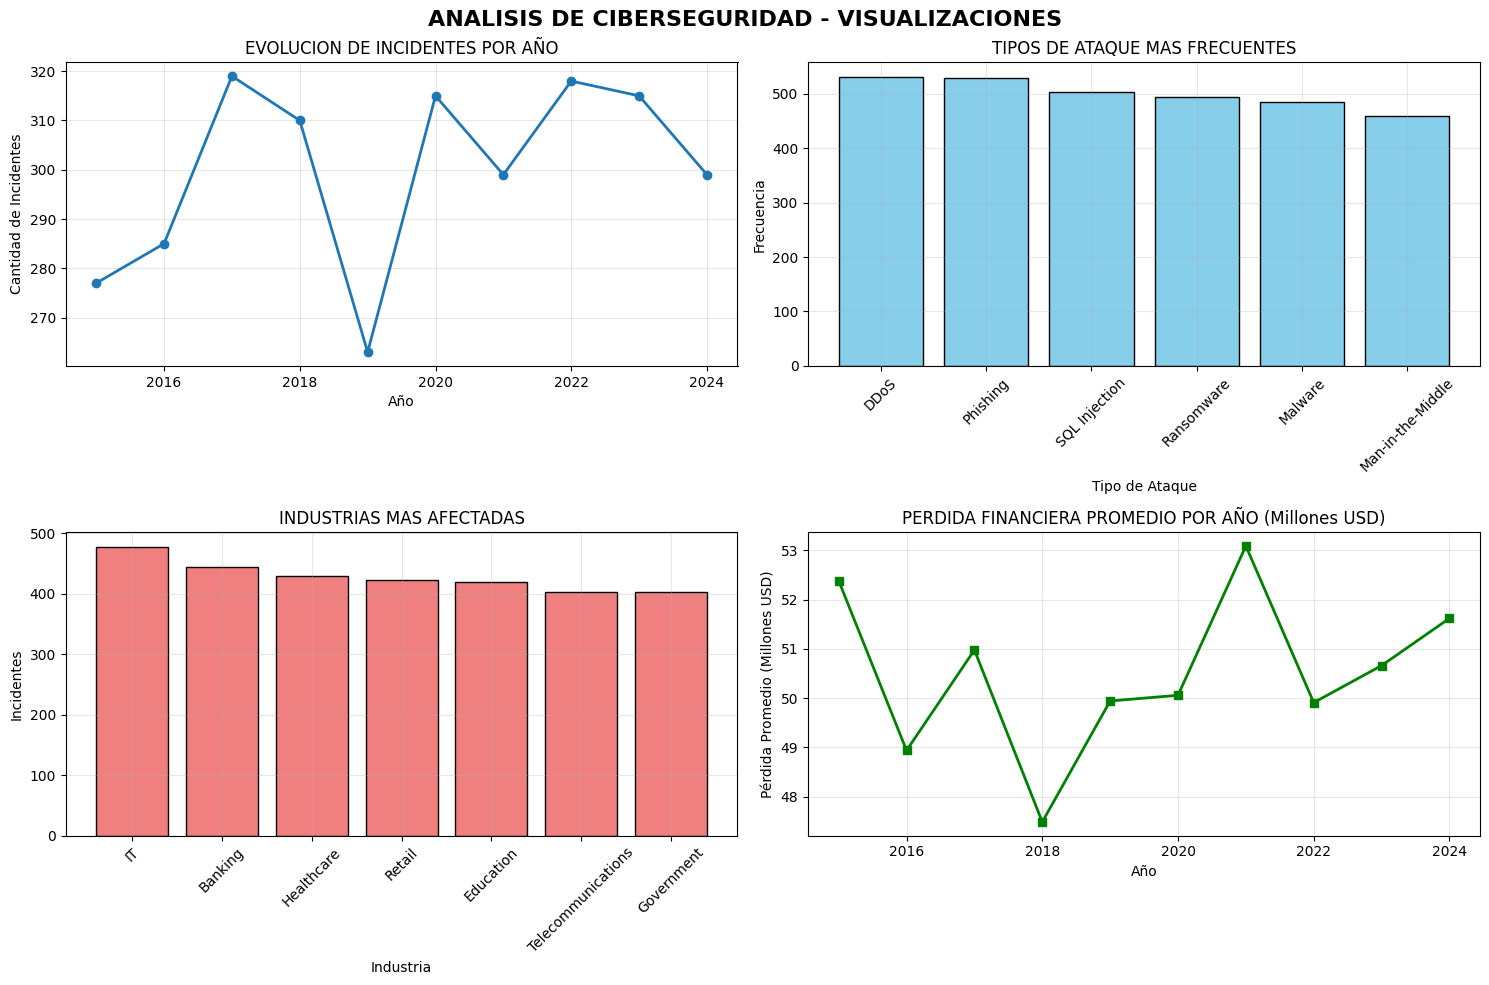

In [0]:
print("=== CREANDO VISUALIZACIONES BASICAS ===")

import matplotlib.pyplot as plt

# Configurar el estilo de los gráficos
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ANALISIS DE CIBERSEGURIDAD - VISUALIZACIONES', fontsize=16, fontweight='bold')

# Gráfico 1: Línea - Evolución temporal de incidentes
axes[0, 0].plot(evolucion_pd['Year'], evolucion_pd['total_incidentes'], marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('EVOLUCION DE INCIDENTES POR AÑO')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Cantidad de Incidentes')
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Barras - Tipos de ataque más comunes
axes[0, 1].bar(ataques_pd['Attack Type'], ataques_pd['frecuencia'], color='skyblue', edgecolor='black')
axes[0, 1].set_title('TIPOS DE ATAQUE MAS FRECUENTES')
axes[0, 1].set_xlabel('Tipo de Ataque')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: Barras - Industrias más afectadas
axes[1, 0].bar(industrias_pd['Target Industry'], industrias_pd['incidentes'], color='lightcoral', edgecolor='black')
axes[1, 0].set_title('INDUSTRIAS MAS AFECTADAS')
axes[1, 0].set_xlabel('Industria')
axes[1, 0].set_ylabel('Incidentes')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Línea - Pérdida financiera promedio por año
axes[1, 1].plot(evolucion_pd['Year'], evolucion_pd['perdida_promedio'], marker='s', color='green', linewidth=2, markersize=6)
axes[1, 1].set_title('PERDIDA FINANCIERA PROMEDIO POR AÑO (Millones USD)')
axes[1, 1].set_xlabel('Año')
axes[1, 1].set_ylabel('Pérdida Promedio (Millones USD)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Visualizaciones adicionales

=== VISUALIZACIONES ADICIONALES ===


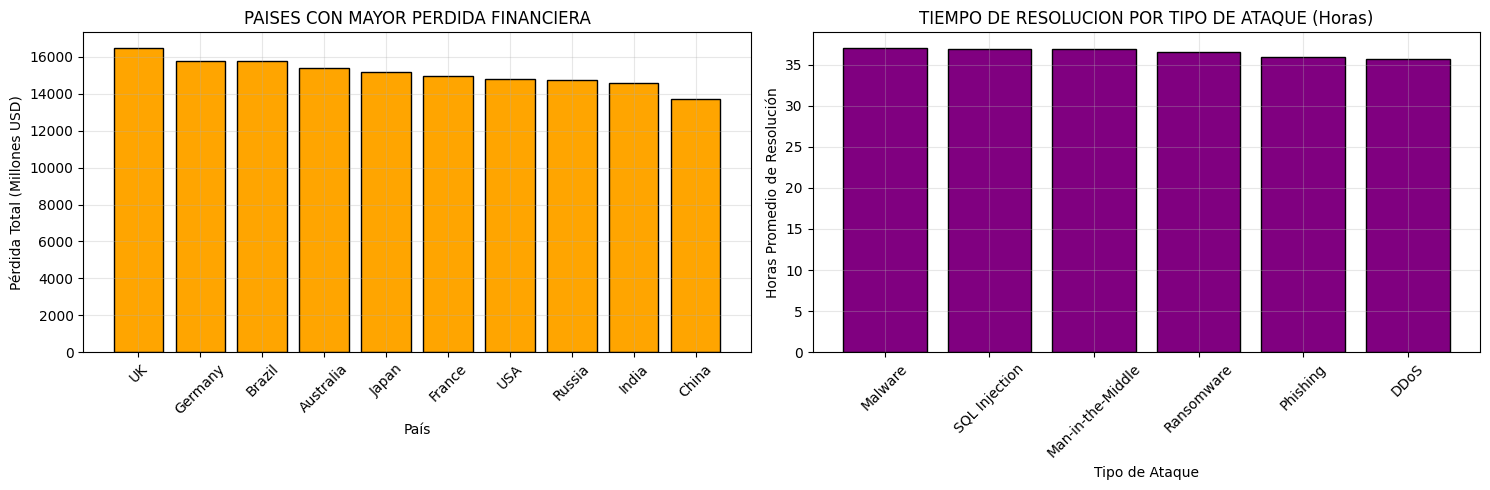

In [0]:
print("=== VISUALIZACIONES ADICIONALES ===")

# Preparar más datos para análisis
paises_perdida = spark.sql(f"""
    SELECT 
        Country,
        SUM(`Financial Loss (in Million $)`) as perdida_total
    FROM {TABLE_NAME}
    GROUP BY Country
    ORDER BY perdida_total DESC
    LIMIT 10
""").toPandas()

resolucion_por_ataque = spark.sql(f"""
    SELECT 
        `Attack Type`,
        AVG(`Incident Resolution Time (in Hours)`) as tiempo_promedio_resolucion
    FROM {TABLE_NAME}
    GROUP BY `Attack Type`
    ORDER BY tiempo_promedio_resolucion DESC
    LIMIT 10
""").toPandas()

# Crear más visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 5: Barras - Países con mayor pérdida financiera
axes[0].bar(paises_perdida['Country'], paises_perdida['perdida_total'], color='orange', edgecolor='black')
axes[0].set_title('PAISES CON MAYOR PERDIDA FINANCIERA')
axes[0].set_xlabel('País')
axes[0].set_ylabel('Pérdida Total (Millones USD)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Gráfico 6: Barras - Tiempo de resolución por tipo de ataque
axes[1].bar(resolucion_por_ataque['Attack Type'], resolucion_por_ataque['tiempo_promedio_resolucion'], color='purple', edgecolor='black')
axes[1].set_title('TIEMPO DE RESOLUCION POR TIPO DE ATAQUE (Horas)')
axes[1].set_xlabel('Tipo de Ataque')
axes[1].set_ylabel('Horas Promedio de Resolución')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Interpretaciones de resultados y conclusiones

In [0]:
print("=== INTERPRETACION DE RESULTADOS Y CONCLUSIONES ===")

print("ANALISIS DE LOS RESULTADOS:")
print("=" * 50)

# Obtener estadísticas clave para el análisis
stats = spark.sql(f"""
    SELECT 
        COUNT(*) as total_incidentes,
        AVG(`Financial Loss (in Million $)`) as perdida_promedio,
        MAX(`Financial Loss (in Million $)`) as perdida_maxima,
        AVG(`Number of Affected Users`) as usuarios_promedio,
        AVG(`Incident Resolution Time (in Hours)`) as tiempo_resolucion_promedio
    FROM {TABLE_NAME}
""").collect()[0]

top_ataque = spark.sql(f"""
    SELECT `Attack Type`, COUNT(*) as count
    FROM {TABLE_NAME}
    GROUP BY `Attack Type`
    ORDER BY count DESC
    LIMIT 1
""").collect()[0]

top_industria = spark.sql(f"""
    SELECT `Target Industry`, COUNT(*) as count
    FROM {TABLE_NAME}
    GROUP BY `Target Industry`
    ORDER BY count DESC
    LIMIT 1
""").collect()[0]

print(f"1. ESCALA DEL DATASET:")
print(f"   - Total de incidentes analizados: {stats['total_incidentes']:,}")
print(f"   - Perdida financiera promedio por incidente: ${stats['perdida_promedio']:.2f} millones")
print(f"   - Usuarios afectados promedio por incidente: {stats['usuarios_promedio']:,.0f}")

print(f"\n2. HALLAZGOS PRINCIPALES:")
print(f"   - Tipo de ataque mas frecuente: {top_ataque['Attack Type']} ({top_ataque['count']} incidentes)")
print(f"   - Industria mas afectada: {top_industria['Target Industry']} ({top_industria['count']} incidentes)")
print(f"   - Tiempo promedio de resolucion: {stats['tiempo_resolucion_promedio']:.1f} horas")

print(f"\n3. TENDENCIAS TEMPORALES:")
# Analizar tendencia de crecimiento
crecimiento = spark.sql(f"""
    SELECT 
        MAX(Year) as ultimo_anio,
        MIN(Year) as primer_anio,
        COUNT(*) as total
    FROM {TABLE_NAME}
""").collect()[0]

print(f"   - Periodo analizado: {crecimiento['primer_anio']} - {crecimiento['ultimo_anio']}")

print(f"\n4. IMPACTO ECONOMICO:")
perdida_total = spark.sql(f"""
    SELECT SUM(`Financial Loss (in Million $)`) as total
    FROM {TABLE_NAME}
""").collect()[0]

print(f"   - Perdida financiera total: ${perdida_total['total']:,.2f} millones")
print(f"   - Perdida maxima registrada: ${stats['perdida_maxima']:.2f} millones")

print(f"\n5. CONCLUSIONES SIMPLES:")
print("   - Los incidentes de ciberseguridad tienen impactos economicos significativos")
print("   - Ciertos tipos de ataques son mas prevalentes que otros")
print("   - Algunas industrias son blancos mas frecuentes de ataques")
print("   - El tiempo de resolucion varia segun el tipo de ataque")
print("   - Existen patrones claros en la distribucion geografica de incidentes")

print("\n" + "=" * 50)
print("ANALISIS COMPLETADO EXITOSAMENTE")

=== INTERPRETACION DE RESULTADOS Y CONCLUSIONES ===
ANALISIS DE LOS RESULTADOS:
1. ESCALA DEL DATASET:
   - Total de incidentes analizados: 3,000
   - Perdida financiera promedio por incidente: $50.49 millones
   - Usuarios afectados promedio por incidente: 504,684

2. HALLAZGOS PRINCIPALES:
   - Tipo de ataque mas frecuente: DDoS (531 incidentes)
   - Industria mas afectada: IT (478 incidentes)
   - Tiempo promedio de resolucion: 36.5 horas

3. TENDENCIAS TEMPORALES:
   - Periodo analizado: 2015 - 2024

4. IMPACTO ECONOMICO:
   - Perdida financiera total: $151,478.91 millones
   - Perdida maxima registrada: $99.99 millones

5. CONCLUSIONES SIMPLES:
   - Los incidentes de ciberseguridad tienen impactos economicos significativos
   - Ciertos tipos de ataques son mas prevalentes que otros
   - Algunas industrias son blancos mas frecuentes de ataques
   - El tiempo de resolucion varia segun el tipo de ataque
   - Existen patrones claros en la distribucion geografica de incidentes

ANALISI